# Applied AI Assignment 3
## Semantic Segmentation using Deep Learning Methods
### Pytorch implementation of Unet, PSPNet, DeepLabV3

In [ ]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch
!pip install tqdm

In [86]:
# Importing the libraries
import glob
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import random
import os
import json
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import torchvision.transforms as T
import albumentations as A
import torch.nn.functional as F
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import KFold
from google.colab import files

# Helper Functions

In [18]:
# Read in the text file
with open('/content/drive/MyDrive/Cam101/label_colors.txt', 'r') as f:
    lines = f.readlines()

# Create empty arrays for the labels and colors
label_map = []
color_map = np.zeros((len(lines), 3), dtype=np.uint8)

# Parse the lines of the text file and fill in the labels and colors arrays
for idx, line in enumerate(lines):
    parts = line.strip().replace('\t\t', '\t').split('\t')
    color_parts = parts[0].split()
    if len(color_parts) != 3:
        print(f"Skipping line {idx+1} because it does not have the expected format")
        continue
    else:
        color = tuple(map(int, color_parts))
    label_map.append(parts[1])
    color_map[idx] = color

label_map = [x.lower() for x in label_map]

colorDict = dict(enumerate(color_map))
labelDict = dict(enumerate(label_map))

dataset_directory = "/content/drive/MyDrive/Cam101/train"

# Find all filenames that have the .png extension
png_filenames = glob.glob(os.path.join(dataset_directory, "*.png"))

# Exclude filenames that have the _L.png suffix
image_filenames = [filename for filename in png_filenames if "_L.png" not in filename]

# Creating a Dataset Class to prepare the data (load/read/transform/dataloader)
class CambridgeVideoDataset(Dataset):
    def __init__(self, image_filenames, dataset_directory, transform, colorDict):
        self.image_filenames = image_filenames
        self.dataset_directory = dataset_directory
        self.colorDict = colorDict
        self.numClass = len(colorDict)

        # Train on crops, predict masks for full-sized images
        if transform == 'train':
            self.transform = A.Compose([
                    A.PadIfNeeded(min_height=256, min_width=256),
                    A.RandomCrop(256, 256),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ])
        elif transform == 'validate':
            self.transform = A.Compose([
                    A.PadIfNeeded(min_height=256, min_width=256),
                    A.CenterCrop(256, 256),
                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ])
        elif transform == 'test':
            # UNet requires that the size of an image will be divisible by 16
            self.transform = A.Compose([
                    A.PadIfNeeded(min_height=736, min_width=960, border_mode=cv2.BORDER_CONSTANT),
                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ])
        else:
            self.transform = None

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Getting the orignal image
        image_filename = self.image_filenames[idx]
        image = cv2.imread(image_filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Getting the mask associated to the image
        mask_filename = f"{image_filename[:-4]}_L.png"
        mask = cv2.imread(mask_filename)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # Data Augmentation
        transformed = self.transform(image=image, mask=mask)
        image_transformed = transformed["image"]
        mask_transformed = transformed["mask"]

        # Encoding mask
        mask_encoded = self.onehot_encoding(mask_transformed)

        # Converting images and mask to tensor
        to_tensor = A.Compose([ToTensorV2()])
        to_tensored = to_tensor(image=image_transformed, mask=mask_encoded)
        image_transformed = to_tensored["image"]
        mask_encoded = to_tensored["mask"].permute(2,0,1)

        return image_transformed, mask_encoded

    # img = 256 x 256 x 3
    # encode = height x weidth x numClass
    def onehot_encoding(self, mask):
        maskShape = mask.shape[:2] + (self.numClass,)
        encode = np.zeros(maskShape, dtype=np.int8)

        for idx, colors in enumerate(self.colorDict):
            encode[:,:,idx] = np.all(mask.reshape((-1,3)) == self.colorDict[idx], axis=1).reshape(maskShape[:2])
        return encode

# Train-validation Split
def trainValSplitLoader(images, splitRatio, dataset_directory, colorDict):
    split_idx = int(len(images) * splitRatio)
    train_set = random.sample(images, split_idx)
    val_set = [x for x in images if x not in train_set]

    # Passing through the custom dataset
    train_dataset = CambridgeVideoDataset(image_filenames=train_set, dataset_directory=dataset_directory, transform='train', colorDict=colorDict)
    val_dataset = CambridgeVideoDataset(image_filenames=val_set, dataset_directory=dataset_directory, transform='validate',colorDict=colorDict)

    # Loading the data
    trainloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
    validationloader = DataLoader(val_dataset, batch_size=10, shuffle=False)

    return trainloader, validationloader

def visualize_augmentations(dataset, idx=0, samples=2):
    dataset = copy.deepcopy(dataset)
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(5, 6))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image.permute(1, 2, 0))
        ax[i, 1].imshow(mask.permute(1,2,0), interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

Loading up the dataset

In [8]:
# Passing through dataset class
full_dataset = CambridgeVideoDataset(image_filenames=image_filenames, dataset_directory=dataset_directory, transform='validate',colorDict=colorDict)

# Train-test Split Loader
trainloader, validationloader = trainValSplitLoader(images=image_filenames, splitRatio=0.9, dataset_directory=dataset_directory, colorDict=colorDict)

# Loading up the testing dataset
test_dataset = CambridgeVideoDataset(image_filenames=image_filenames, dataset_directory=dataset_directory, transform='test',colorDict=colorDict)
testloader = DataLoader(test_dataset, batch_size=10, shuffle=True)

# Getting the dictionary key of each class label
labelKeys = list(labelDict.keys())

# Train samples
train_directory = "/content/drive/MyDrive/Cam101/train"
test_directory = "/content/drive/MyDrive/Cam101/test"

# Find all filenames that have the .png extension
png_trainfilenames = glob.glob(os.path.join(train_directory, "*.png"))
png_testfilenames = glob.glob(os.path.join(test_directory, "*.png"))

print("Number of train images and masks:", len(png_trainfilenames))
print("Number of test images and masks:", len(png_testfilenames))

Number of train images and masks: 180
Number of test images and masks: 22


Visualizing the dataset

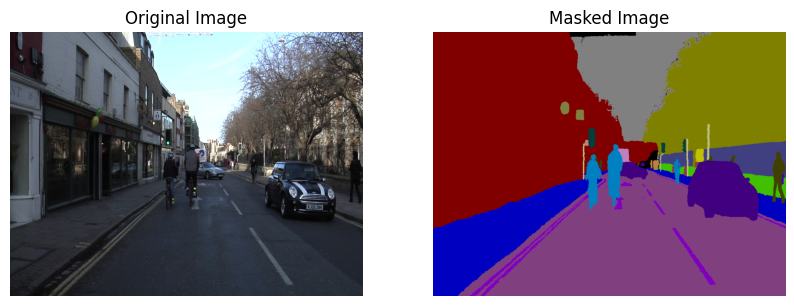

In [87]:
# Exclude filenames that have the _L.png suffix
image = imread(image_filenames[0])
mask = imread(f"{image_filenames[0][:-4]}_L.png")

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# Plot images on subplots
ax1.imshow(image)
ax1.set_title('Original Image')
ax1.set_axis_off()
ax2.imshow(mask)
ax2.set_title('Masked Image')
ax2.set_axis_off()

# Display the plot
plt.show()

Visualizing the augmentations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


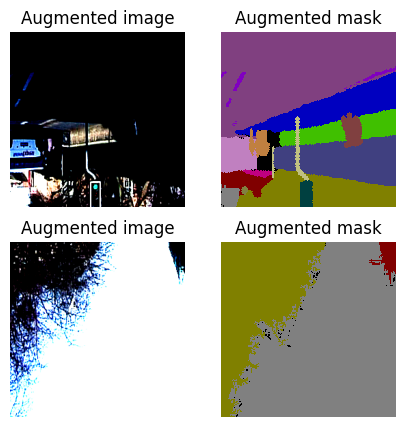

In [76]:
visualize_augmentations(full_dataset, idx=55)

Creating the training function

In [ ]:
def create_training(model, labelKeys, DEVICE, lr, lossName, optimizer):

    # Selecting the loss function
    if lossName == 'Dice_loss':
        loss = smp.losses.DiceLoss(mode='multilabel', classes=labelKeys)
        loss.__name__ = 'Dice_loss'
    else:
        loss = smp.losses.TverskyLoss(mode='multilabel', classes=labelKeys)
        loss.__name__ = 'Tversky_loss'

    # Selecting the activation function
    if optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

    # Fixed parameters
    metrics = [
        smp.utils.metrics.IoU(threshold=0.5),
        smp.utils.metrics.Fscore(threshold=0.5),
        smp.utils.metrics.Accuracy(threshold=0.5),
    ]

    # create epoch runners simple loop of iterating over dataloader`s samples
    train_epoch = smp.utils.train.TrainEpoch(model, loss=loss,metrics=metrics,
                                             optimizer=optimizer,device=DEVICE,verbose=True,)

    valid_epoch = smp.utils.train.ValidEpoch(model, loss=loss, metrics=metrics,
                                             device=DEVICE,verbose=True,)

    return train_epoch, valid_epoch

K-Cross Validation Function

In [ ]:
def folding(numFold, numEpoch, lr, lossName, optimizer, model, labelKeys, DEVICE):

    # Create the training function
    train_epoch, valid_epoch = create_training(model=model, labelKeys=labelKeys,
                                               DEVICE=DEVICE, lr=lr, lossName=lossName, optimizer=optimizer)
    kfold = KFold(n_splits=numFold, shuffle=True)

    # Initializing the trackers
    trainDict = {'loss': [], 'score': [], 'accuracy': []}
    valDict = {'loss': [], 'score': [], 'accuracy': []}

    for fold, (trainIdx, valIdx) in enumerate(kfold.split(full_dataset)):
        train_subsampler = torch.utils.data.SubsetRandomSampler(trainIdx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(valIdx)

        # Define data loaders for training and testing data in this fold
        trainloader = torch.utils.data.DataLoader(full_dataset, batch_size=10, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(full_dataset, batch_size=10, sampler=val_subsampler)

        for epoch in range(numEpoch):

            # running the model
            train_logs = train_epoch.run(trainloader)

            trainDict['loss'].append(train_logs[lossName])
            trainDict['score'].append(train_logs['iou_score'])

        valid_logs = valid_epoch.run(validationloader)
        valDict['loss'].append(valid_logs[lossName])
        valDict['score'].append(valid_logs['iou_score'])

    return valDict, trainDict

Final Training Function

In [ ]:
def training(numEpoch, lr, trainloader, validationloader, lossName, optimizer, model, labelKeys, DEVICE):
    train_epoch, valid_epoch = create_training(model=model, labelKeys=labelKeys,
                                               DEVICE=DEVICE, lr=lr, lossName=lossName, optimizer=optimizer)

    trainDict = {'loss': [], 'score': [], 'accuracy': []}
    valDict = {'loss': [], 'score': [], 'accuracy': []}

    print('--------------------------------')
    for epoch in range(numEpoch):
        print(f'EPOCH {epoch}')

        # Training the model
        start = time.time()
        train_logs = train_epoch.run(trainloader)
        trainDict['loss'].append(train_logs[lossName])
        trainDict['score'].append(train_logs['iou_score'])
        trainDict['accuracy'].append(train_logs['accuracy'])

        end = time.time()

        valid_logs = valid_epoch.run(validationloader)
        valDict['loss'].append(valid_logs[lossName])
        valDict['score'].append(valid_logs['iou_score'])
        valDict['accuracy'].append(valid_logs['accuracy'])

        print(f'TIME TAKEN: {end-start}')
        print('--------------------------------')

    # Saving the model at checkpoints
        if (epoch%10) == 0:
            torch.save(model, '/content/drive/My Drive/Cam101/checkpoint.pth')

    return valDict, trainDict

Train Visualizer

In [2]:
def trainVisualization(trainDict, valDict):
    # plot train and validation loss values
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    # plot train and validation loss values
    axs[0].plot(trainDict['loss'], label='Train Loss')
    axs[0].plot(valDict['loss'], label='Validation Loss')
    axs[0].legend()
    axs[0].set_title('Dice Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')

    # plot train and validation score values
    axs[1].plot(trainDict['score'], label='Train Score')
    axs[1].plot(valDict['score'], label='Validation Score')
    axs[1].legend()
    axs[1].set_title('mIOU Scores')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Score')

    # plot train and validation accuracy values
    axs[2].plot(trainDict['accuracy'], label='Train Accuracy')
    axs[2].plot(valDict['accuracy'], label='Validation Accuracy')
    axs[2].legend()
    axs[2].set_title('Pixel Accuracy')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Accuracy')

    plt.show()

Testing functions

In [ ]:
# Loading up the test dataset and the saved model
dataset_directory = "/content/drive/MyDrive/Cam101/test"

# Find all filenames that have the .png extension
png_filenames = glob.glob(os.path.join(dataset_directory, "*.png"))

# Exclude filenames that have the _L.png suffix
image_filenames = [filename for filename in png_filenames if "_L.png" not in filename]

test_dataset = CambridgeVideoDataset(image_filenames=image_filenames, dataset_directory=dataset_directory, transform='test',colorDict=colorDict)
testloader = DataLoader(test_dataset, batch_size=10, shuffle=True)

Testing Visualizer

In [19]:
def onehot_decoding(onehot, colorDict):
  # Getting the mask class
  single_layer = np.argmax(onehot, axis=-1)
  output = np.zeros( onehot.shape[:2]+(3,) )

  # Decoding the mask
  for k in colorDict.keys():
    output[single_layer==k] = colorDict[k]
  return np.uint64(output)

def visualiseTest(testloader, model):
  # Get the next batch of images
  image, mask = next(iter(testloader))

  # Prediction and convert to image
  pred_all = model(image)
  pred_all_shaped = pred_all.detach().numpy()
  pred_all_shaped = np.transpose(pred_all_shaped, (0,2,3,1))

  mask_shaped = mask.detach().numpy()
  mask_shaped = np.transpose(mask_shaped, (0,2,3,1))

  # Plotting images
  for i in range(np.shape(pred_all)[0]):
    fig = plt.figure(figsize=(20,8))
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(image[i].permute(1, 2, 0))
    ax1.title.set_text('Actual frame')

    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground truth mask')
    ax2.imshow(onehot_decoding(mask_shaped[i],colorDict))

    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted mask')
    ax3.imshow(onehot_decoding(pred_all_shaped[i],colorDict))

    plt.show()

# Unet Implementation

Creating the Unet Model

In [ ]:
# The parameters
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = labelDict
ACTIVATION = 'softmax2d'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Creating the model
modelUnet = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS,
                 classes=len(CLASSES), activation=ACTIVATION,)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Tversky Loss vs Dice Loss

In [50]:
numFold = 3
numEpoch = 10
lr = 0.01
lossNames = ['Dice_loss', 'Tversky_loss']
optimizer = 'Adam'

for lossName in lossNames:
    valDict, trainDict = folding(numFold=numFold, numEpoch=numEpoch, lr=lr, lossName=lossName, optimizer=optimizer,
                                 model=modelUnet, labelKeys=labelKeys, DEVICE=DEVICE)
    avgTrainLoss = np.mean(trainDict['loss'])
    avgTrainScore = np.mean(trainDict['score'])
    avgValLoss = np.mean(valDict['loss'])
    avgvalScore = np.mean(valDict['score'])

    print(lossName)
    print(f"avgTrainLoss : {avgTrainLoss:.3f} | avgTrainScore: {avgTrainScore:.3f}")
    print(f"avgValLoss : {avgValLoss:.3f} | avgvalScore: {avgvalScore:.3f}")

Dice_loss
avgTrainLoss : 0.587 | avgTrainScore: 0.580
avgValLoss : 0.583 | avgvalScore: 0.636


Tversky_Loss
avgTrainLoss : 0.586 | avgTrainScore: 0.563
avgValLoss : 0.586 | avgvalScore: 0.606


Dice loss will be used since it has the higher average validation score and lower average validation loss.

Next, testing the optimizers

In [49]:
numFold = 3
numEpoch = 10
lr = 0.01
lossName = 'Dice_loss'
optimizerList = ['Adam', 'RMSprop', 'SGD']

for optimizer in optimizerList:
    valDict, trainDict = folding(numFold=numFold, numEpoch=numEpoch, lr=lr, lossName=lossName, optimizer=optimizer,
                                 model=modelUnet, labelKeys=labelKeys, DEVICE=DEVICE)
    avgTrainLoss = np.mean(trainDict['loss'])
    avgTrainScore = np.mean(trainDict['score'])
    avgValLoss = np.mean(valDict['loss'])
    avgvalScore = np.mean(valDict['score'])

    print(optimizer)
    print(f"avgTrainLoss : {avgTrainLoss:.3f} | avgTrainScore: {avgTrainScore:.3f}")
    print(f"avgValLoss : {avgValLoss:.3f} | avgvalScore: {avgvalScore:.3f}")

Adam
avgTrainLoss : 0.581 | avgTrainScore: 0.782
avgValLoss : 0.57 | avgvalScore: 0.757


RMSprop
avgTrainLoss : 0.589 | avgTrainScore: 0.257
avgValLoss : 0.583 | avgvalScore: 0.225


SGD
avgTrainLoss : 0.59 | avgTrainScore: 0.283
avgValLoss : 0.581 | avgvalScore: 0.284


Adam optimizer has the best performance.

Next, testing the learning rates

In [48]:
numFold = 3
numEpoch = 10
lossName = 'Dice_loss'
lrList = [0.01, 0.001, 0.0001]
optimizer = 'Adam'

for lr in lrList:
    valDict, trainDict = folding(numFold=numFold, numEpoch=numEpoch, lr=lr, lossName=lossName, optimizer=optimizer,
                                 model=modelUnet, labelKeys=labelKeys, DEVICE=DEVICE)
    avgTrainLoss = np.mean(trainDict['loss'])
    avgTrainScore = np.mean(trainDict['score'])
    avgValLoss = np.mean(valDict['loss'])
    avgvalScore = np.mean(valDict['score'])

    print(lr)
    print(f"avgTrainLoss : {avgTrainLoss:.3f} | avgTrainScore: {avgTrainScore:.3f}")
    print(f"avgValLoss : {avgValLoss:.3f} | avgvalScore: {avgvalScore:.3f}")

0.01
avgTrainLoss: 0.326 | avgTrainScore: 0.518
avgValLoss: 0.377 | avgValScore: 0.461


0.001
avgTrainLoss: 0.394 | avgTrainScore: 0.552
avgValLoss: 0.333 | avgValScore: 0.602


0.0001
avgTrainLoss: 0.707 | avgTrainScore: 0.298
avgValLoss: 0.619 | avgValScore: 0.417


Learning Rate = 0.001 yields the best results, hence it will be used in the final model training

Final Training

In [7]:
numEpoch = 100
lr = 0.001
lossName = 'Dice_loss'
optimizer = 'Adam'
valDict, trainDict= training(numEpoch=numEpoch, lr=lr, trainloader=trainloader, validationloader=validationloader,
         lossName=lossName, optimizer=optimizer, model=modelUnet, labelKeys=labelKeys)

--------------------------------
EPOCH 0
valid: 100%|██████████| 1/1 [00:04<00:00,  4.55s/it, Dice_loss - 0.5403, iou_score - 0.1509, fscore - 0.2622, accuracy - 0.9614]
Checkpoint saved!
TIME TAKEN: 113.47485685348511
--------------------------------
EPOCH 1
valid: 100%|██████████| 1/1 [00:04<00:00,  4.06s/it, Dice_loss - 0.5397, iou_score - 0.1739, fscore - 0.2962, accuracy - 0.9646]
TIME TAKEN: 108.1137044429779
--------------------------------
EPOCH 2
valid: 100%|██████████| 1/1 [00:04<00:00,  4.88s/it, Dice_loss - 0.5422, iou_score - 0.0492, fscore - 0.09379, accuracy - 0.9513]
TIME TAKEN: 109.60829949378967
--------------------------------
EPOCH 3
valid: 100%|██████████| 1/1 [00:03<00:00,  4.00s/it, Dice_loss - 0.5402, iou_score - 0.1444, fscore - 0.2524, accuracy - 0.9606]
TIME TAKEN: 107.99343609809875
--------------------------------
EPOCH 4
valid: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it, Dice_loss - 0.5392, iou_score - 0.1808, fscore - 0.3062, accuracy - 0.9713]
TIME TAK

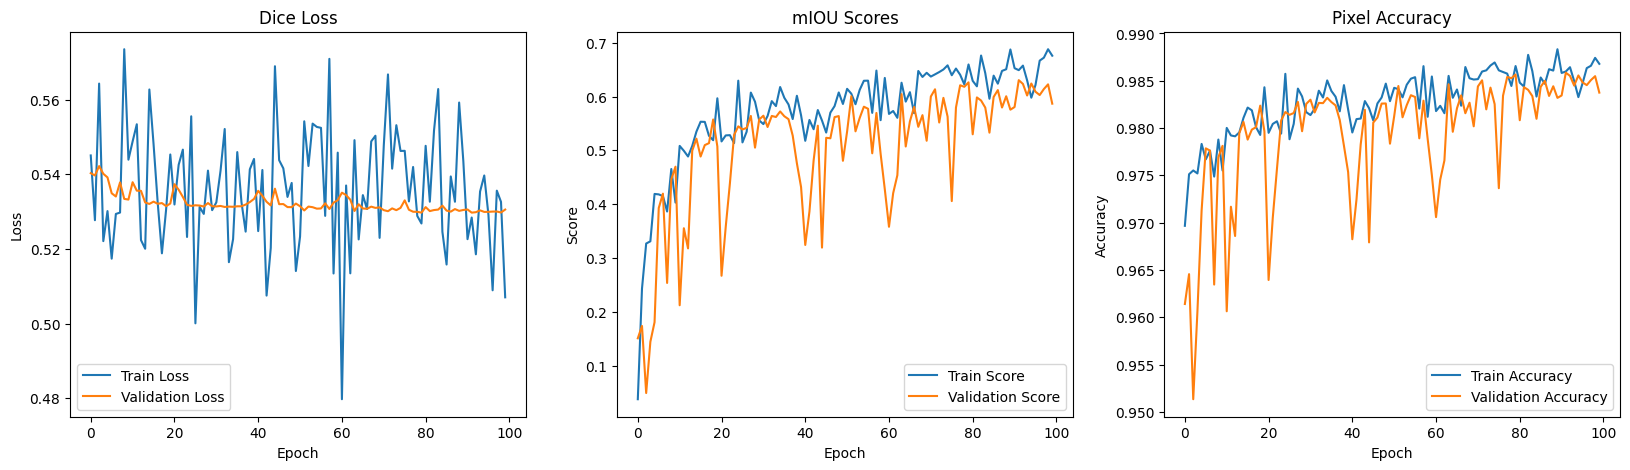

In [14]:
trainVisualization(trainDict=trainDict, valDict=valDict)

In [15]:
avgTrainLoss = np.mean(trainDict['loss'])
avgTrainScore = np.mean(trainDict['score'])
avgTrainPixel= np.mean(trainDict['accuracy'])

avgValLoss = np.mean(valDict['loss'])
avgValScore = np.mean(valDict['score'])
avgValPixel= np.mean(valDict['accuracy'])


print(f"Average Train Dice Loss: {avgTrainLoss:.4f} | Average Train IOU Score: {avgTrainScore:.4f} | Average Train Pixel Accuracy: {avgTrainPixel:.4f}")
print(f"Average Validation Dice Loss: {avgValLoss:.4f} | Average Validation IOU Score: {avgValScore:.4f} | Average Train Pixel Accuracy: {avgValPixel:.4f}")

Average Train Dice Loss: 0.5361 | Average Train IOU Score: 0.5716 | Average Train Pixel Accuracy: 0.9828
Average Validation Dice Loss: 0.5323 | Average Validation IOU Score: 0.5023 | Average Train Pixel Accuracy: 0.9793


Testing

Creating the testing run

In [32]:
# Loading saved trained model
modelBestUnet = torch.load('/content/drive/MyDrive/Cam101/checkpoint.pth')

loss = smp.losses.DiceLoss(mode='multilabel', classes=labelKeys)
loss.__name__ = 'Dice_loss'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(modelUnet.parameters(), lr=0.001)
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
]

# Creating the epoch runner
test_epoch = smp.utils.train.ValidEpoch(model=modelBestUnet, loss=loss, metrics=metrics, device=DEVICE)

# Executing the test
tracker = test_epoch.run(testloader)

valid: 100%|██████████| 2/2 [01:14<00:00, 37.05s/it, Dice_loss - 0.5955, iou_score - 0.6396, fscore - 0.7801, accuracy - 0.9863]


Visualizing predictions

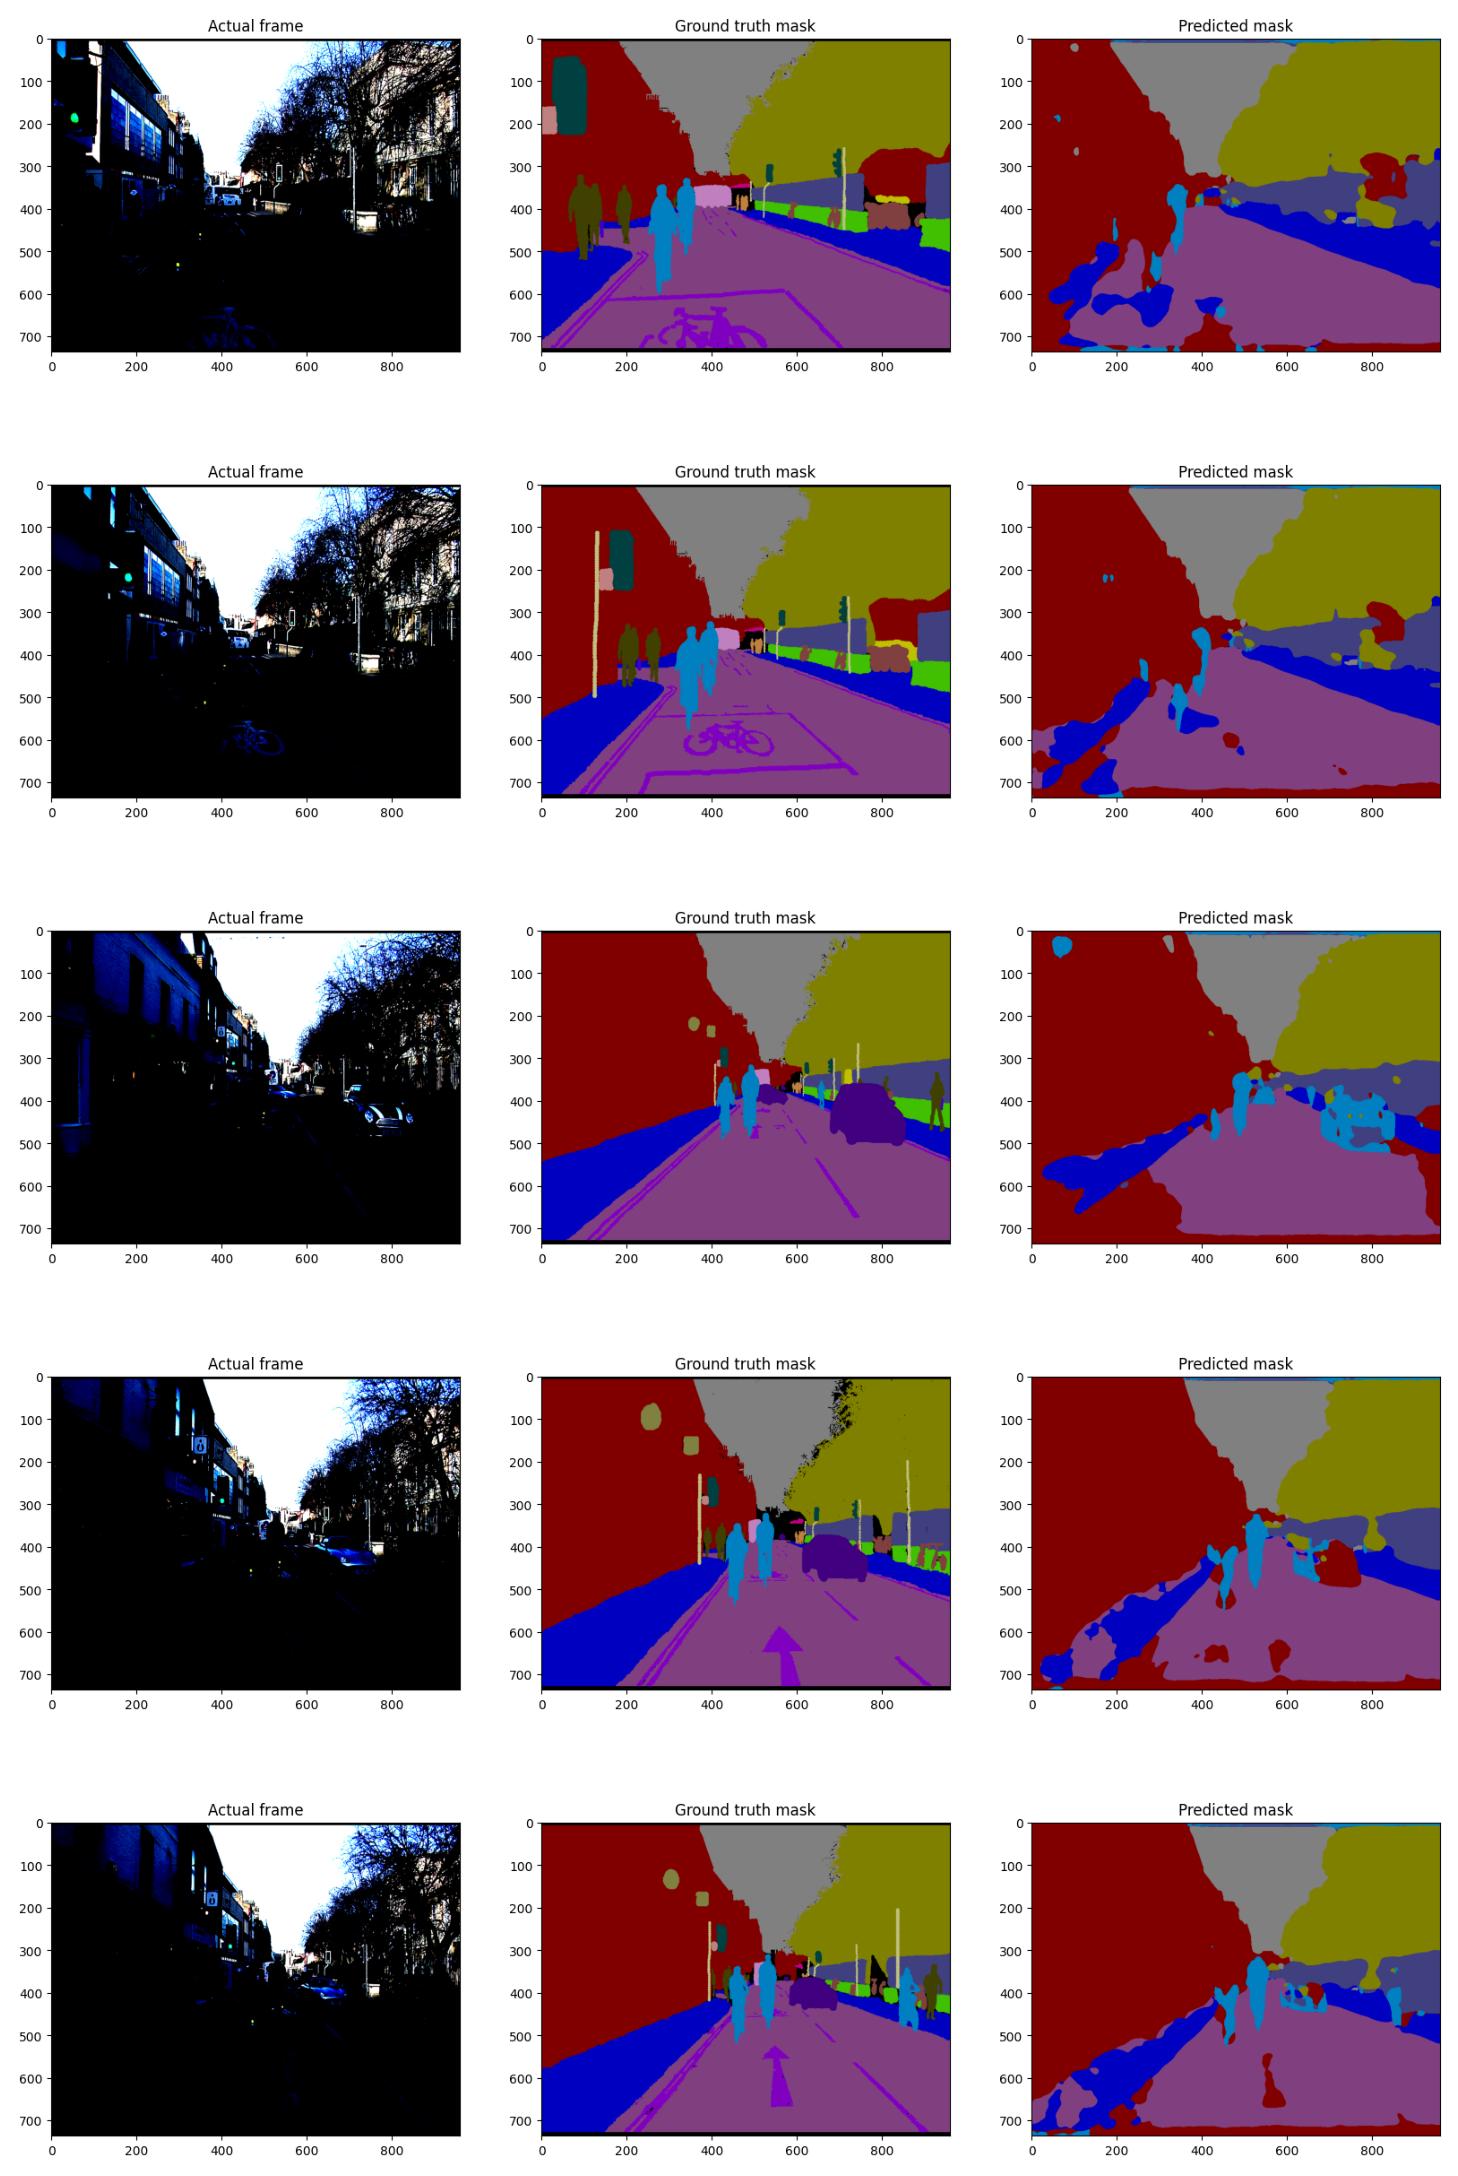

In [79]:
visualiseTest(testloader=testloader, model=modelBestUnet)

# PSPNet Implementation

Creating the PSPNet Model

In [ ]:
# The parameters
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = labelDict
ACTIVATION = 'softmax2d'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Creating the model
modelPSPNet = smp.PSPNet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS,
                 classes=len(CLASSES), activation=ACTIVATION,)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

K-Fold validations

Tversky Loss vs Dice Loss

In [51]:
numFold = 3
numEpoch = 10
lr = 0.01
lossNames = ['Dice_loss', 'Tversky_loss']
optimizer = 'Adam'

for lossName in lossNames:
    valDict, trainDict = folding(numFold=numFold, numEpoch=numEpoch, lr=lr, lossName=lossName, optimizer=optimizer,
                                 model=modelPSPNet, labelKeys=labelKeys, DEVICE=DEVICE)
    avgTrainLoss = np.mean(trainDict['loss'])
    avgTrainScore = np.mean(trainDict['score'])
    avgValLoss = np.mean(valDict['loss'])
    avgvalScore = np.mean(valDict['score'])

    print(lossName)
    print(f"avgTrainLoss : {avgTrainLoss:.3f} | avgTrainScore: {avgTrainScore:.3f}")
    print(f"avgValLoss : {avgValLoss:.3f} | avgvalScore: {avgvalScore:.3f}")

Dice_loss
avgTrainLoss : 0.587 | avgTrainScore: 0.46
avgValLoss : 0.583 | avgvalScore: 0.487


Tversky_loss
avgTrainLoss : 0.586 | avgTrainScore: 0.488
avgValLoss : 0.584 | avgvalScore: 0.496


From the results, both Dice Loss and Tversky Loss have similar performance. We will go with Dice Loss as it is a more common loss function in semantic segmentation.

Next, we will test the different optimizers

In [46]:
numFold = 3
numEpoch = 10
lr = 0.01
lossName = 'Dice_loss'
optimizerList = ['Adam', 'RMSprop', 'SGD']

for optimizer in optimizerList:
    valDict, trainDict = folding(numFold=numFold, numEpoch=numEpoch, lr=lr, lossName=lossName, optimizer=optimizer,
                                 model=modelPSPNet, labelKeys=labelKeys, DEVICE=DEVICE)
    avgTrainLoss = np.mean(trainDict['loss'])
    avgTrainScore = np.mean(trainDict['score'])
    avgValLoss = np.mean(valDict['loss'])
    avgvalScore = np.mean(valDict['score'])

    print(optimizer)
    print(f"avgTrainLoss : {avgTrainLoss:.3f} | avgTrainScore: {avgTrainScore:.3f}")
    print(f"avgValLoss : {avgValLoss:.3f} | avgvalScore: {avgvalScore:.3f}")

Adam
avgTrainLoss : 0.582 | avgTrainScore: 0.593
avgValLoss : 0.581 | avgvalScore: 0.63


RMSprop
avgTrainLoss : 0.584 | avgTrainScore: 0.503
avgValLoss : 0.582 | avgvalScore: 0.504


SGD
avgTrainLoss : 0.599 | avgTrainScore: 0.007
avgValLoss : 0.598 | avgvalScore: 0.005


Adam optimizer is found to perform the best.
Next different learning rates are experimented

In [52]:
numFold = 3
numEpoch = 10
lossName = 'Dice_loss'
lrList = [0.01, 0.001, 0.0001]
optimizer = 'Adam'

for lr in lrList:
    valDict, trainDict = folding(numFold=numFold, numEpoch=numEpoch, lr=lr, lossName=lossName, optimizer=optimizer,
                                 model=modelPSPNet, labelKeys=labelKeys, DEVICE=DEVICE)
    avgTrainLoss = np.mean(trainDict['loss'])
    avgTrainScore = np.mean(trainDict['score'])
    avgValLoss = np.mean(valDict['loss'])
    avgvalScore = np.mean(valDict['score'])

    print(lr)
    print(f"avgTrainLoss : {avgTrainLoss:.3f} | avgTrainScore: {avgTrainScore:.3f}")
    print(f"avgValLoss : {avgValLoss:.3f} | avgvalScore: {avgvalScore:.3f}")

0.01
avgTrainLoss : 0.594 | avgTrainScore:0.210
avgValLoss : 0.594 | avgvalScore: 0.215


0.001
avgTrainLoss : 0.585 | avgTrainScore: 0.503
avgValLoss : 0.582| avgvalScore: 0.504


0.0001
avgTrainLoss : 0.584  | avgTrainScore: 0.656
avgValLoss : 0.580  | avgvalScore: 0.720


From the results, learning rate = 0.0001 has the best results. The final training will be performed on the PSPNet model with a Dice Loss function and learning rate = 0.0001

In [17]:
numEpoch = 100
lr = 0.0001
lossName = 'Dice_loss'
optimizer = 'Adam'
valDict, trainDict= training(numEpoch=numEpoch, lr=lr, trainloader=trainloader, validationloader=validationloader,
         lossName=lossName, optimizer=optimizer, model=modelPSPNet, labelKeys=labelKeys)

--------------------------------
EPOCH 0
valid: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it, Dice_loss - 0.6373, iou_score - 1.695e-13, fscore - 1.695e-13, accuracy - 0.9688, recall - 1.695e-13, precision - 1.0]
TIME TAKEN: 86.80058407783508
--------------------------------
EPOCH 1
valid: 100%|██████████| 1/1 [00:04<00:00,  4.05s/it, Dice_loss - 0.636, iou_score - 0.004121, fscore - 0.008209, accuracy - 0.9688, recall - 0.004132, precision - 0.6207]
TIME TAKEN: 77.60032868385315
--------------------------------
EPOCH 2
valid: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it, Dice_loss - 0.6333, iou_score - 0.2267, fscore - 0.3696, accuracy - 0.9697, recall - 0.2841, precision - 0.5286]
TIME TAKEN: 74.25637984275818
--------------------------------
EPOCH 3
valid: 100%|██████████| 1/1 [00:04<00:00,  4.56s/it, Dice_loss - 0.6309, iou_score - 0.3592, fscore - 0.5285, accuracy - 0.974, recall - 0.4662, precision - 0.6101]
TIME TAKEN: 82.80615735054016
--------------------------------
EPOCH 4
v

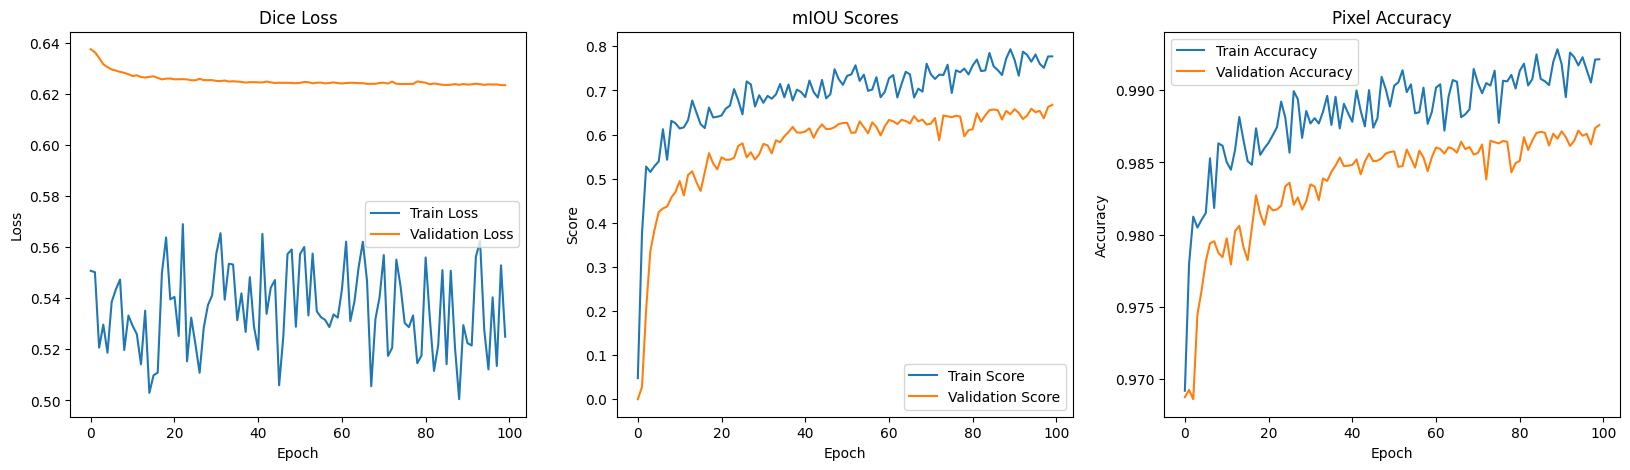

In [15]:
trainVisualization(trainDict=trainDict, valDict=valDict)

In [16]:
avgTrainLoss = np.mean(trainDict['loss'])
avgTrainScore = np.mean(trainDict['score'])
avgTrainPixel= np.mean(trainDict['accuracy'])

avgValLoss = np.mean(valDict['loss'])
avgValScore = np.mean(valDict['score'])
avgValPixel= np.mean(valDict['accuracy'])


print(f"Average Train Dice Loss: {avgTrainLoss:.4f} | Average Train IOU Score: {avgTrainScore:.4f} | Average Train Pixel Accuracy: {avgTrainPixel:.4f}")
print(f"Average Validation Dice Loss: {avgValLoss:.4f} | Average Validation IOU Score: {avgValScore:.4f} | Average Train Pixel Accuracy: {avgValPixel:.4f}")

Average Train Dice Loss: 0.5355 | Average Train IOU Score: 0.6912 | Average Train Pixel Accuracy: 0.9884
Average Validation Dice Loss: 0.6253 | Average Validation IOU Score: 0.5751 | Average Train Pixel Accuracy: 0.9837


Testing

Creating the testing run

In [61]:
# Loading saved trained model
modelBestPSPNet = torch.load('/content/drive/MyDrive/Cam101/checkpointPSPNet.pth')

loss = smp.losses.DiceLoss(mode='multilabel', classes=labelKeys)
loss.__name__ = 'Dice_loss'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(modelPSPNet.parameters(), lr=0.0001)
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
]

test_epoch = smp.utils.train.ValidEpoch(model=modelBestPSPNet, loss=loss, metrics=metrics, device=DEVICE)

# Executing the test
tracker = test_epoch.run(testloader)

valid: 100%|██████████| 11/11 [00:55<00:00,  5.06s/it, Dice_loss - 0.5631, iou_score - 0.7799, fscore - 0.8759, accuracy - 0.9923]


Visualizing predictions

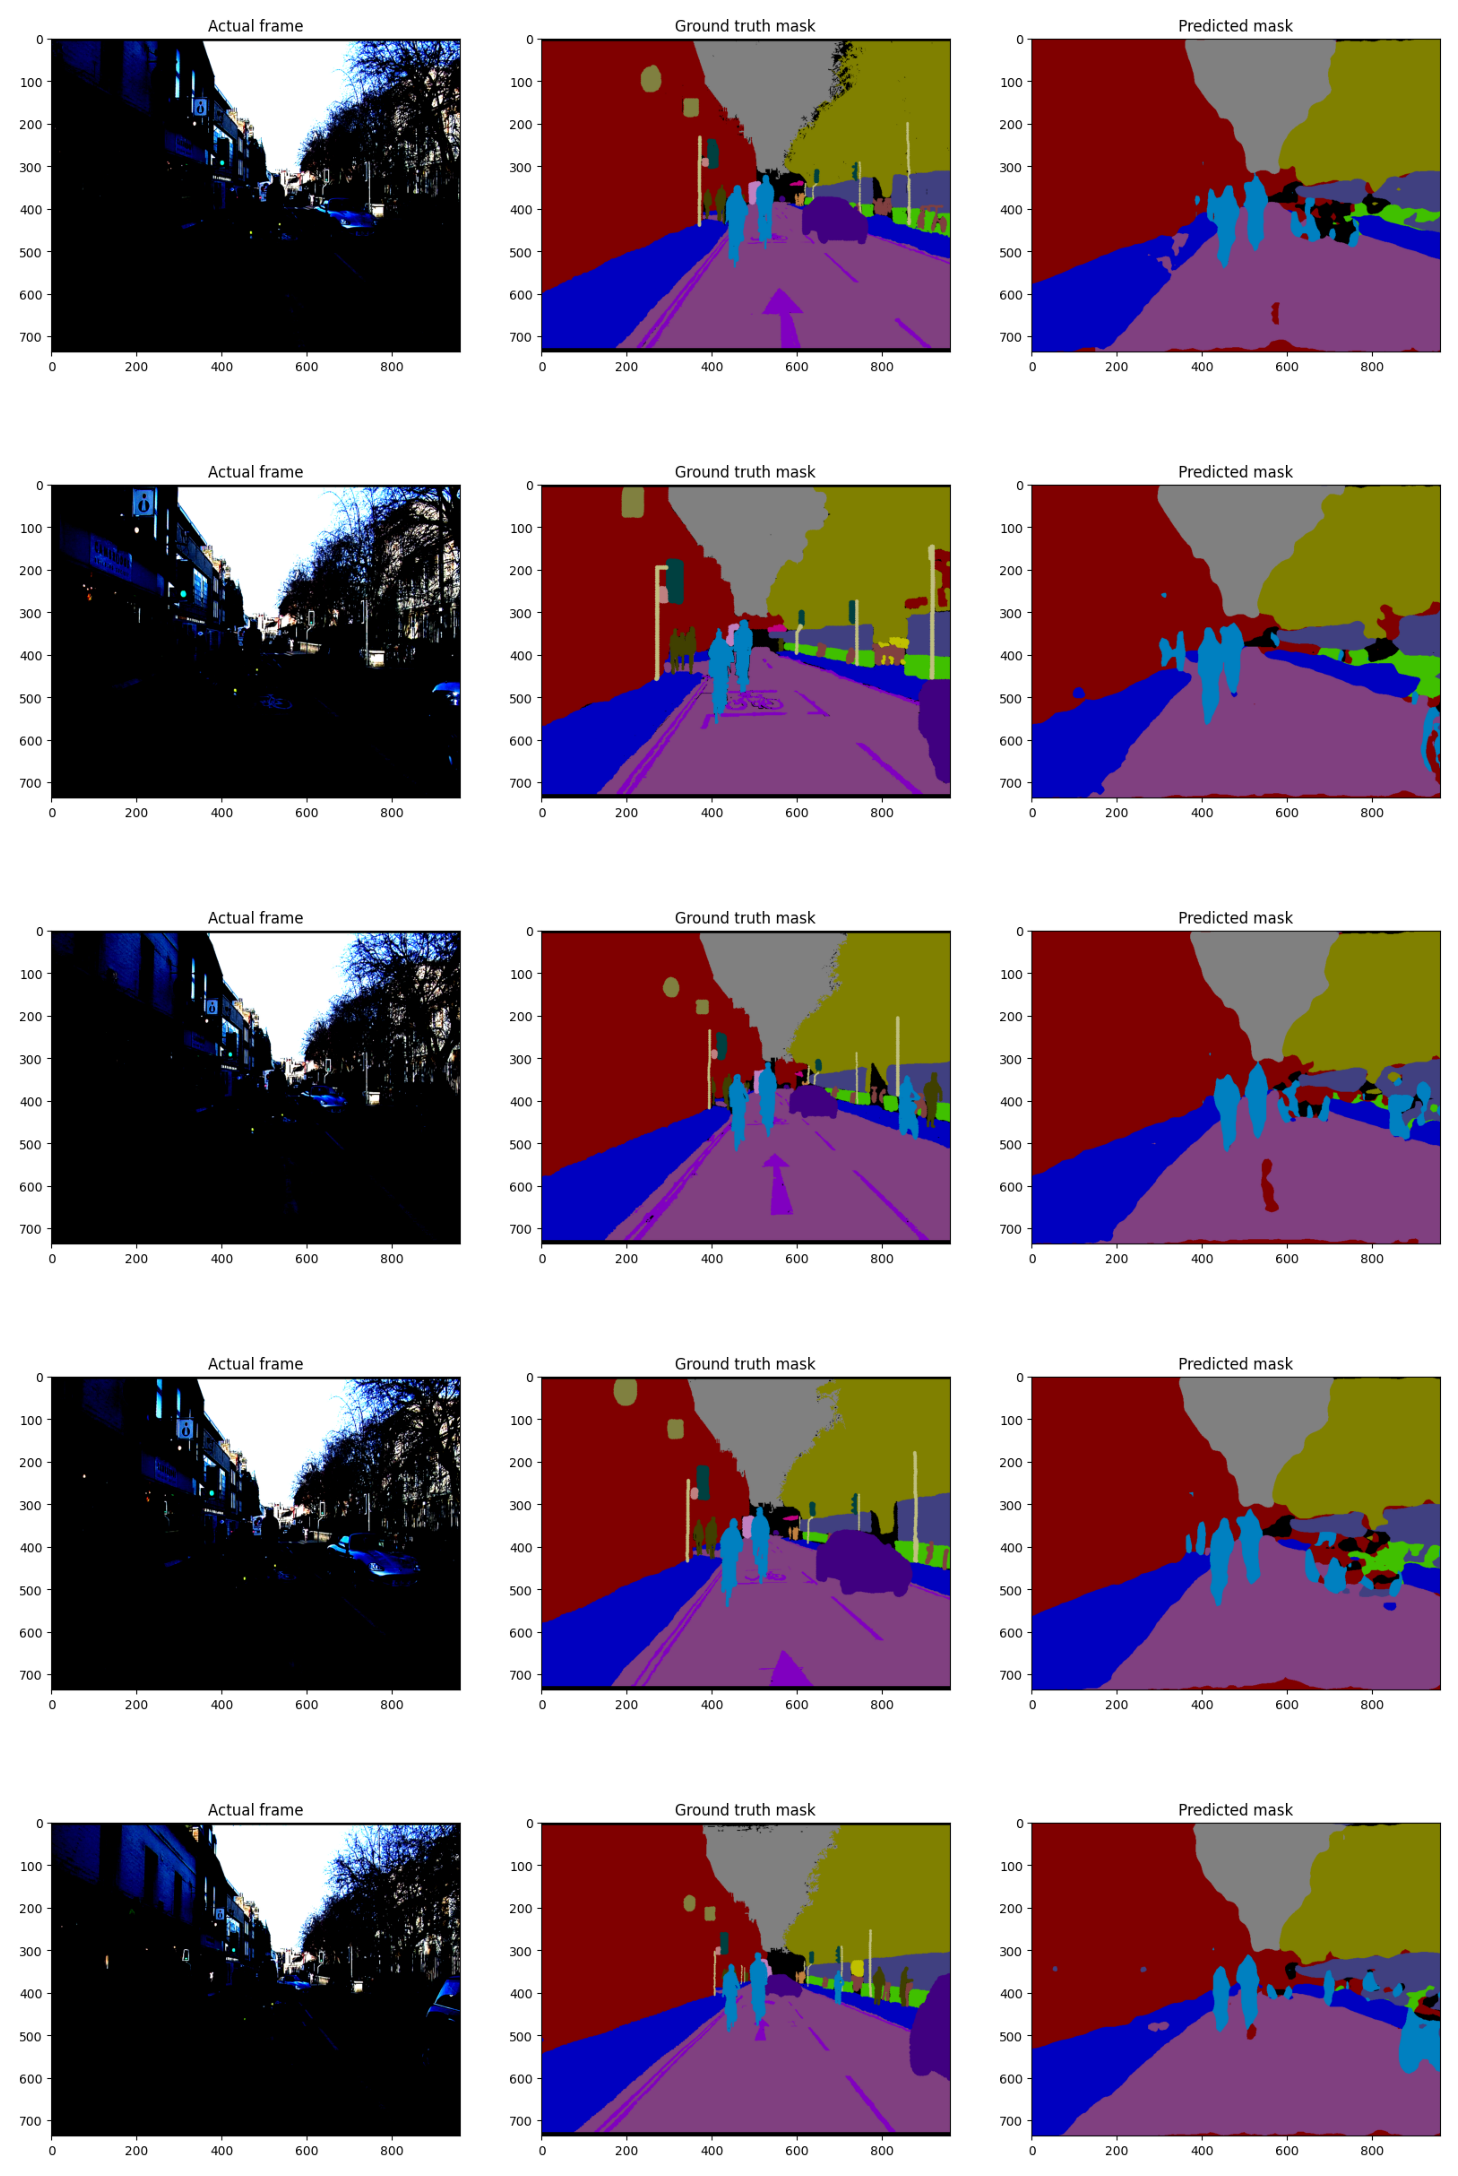

In [78]:
visualiseTest(testloader=testloader, model=modelBestPSPNet)

# DeepLabV3 Implementation

Creating the DeepLab Model

In [ ]:
# The parameters
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = labelDict
ACTIVATION = 'softmax2d'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Creating the model
modelDeepLab= smp.DeepLabV3(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS,
                 classes=len(CLASSES), activation=ACTIVATION,)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Tversky Loss vs Dice Loss

In [11]:
numFold = 3
numEpoch = 10
lr = 0.01
lossNames = ['Dice_loss', 'Tversky_loss']
optimizer = 'Adam'

for lossName in lossNames:
    valDict, trainDict = folding(numFold=numFold, numEpoch=numEpoch, lr=lr, lossName=lossName, optimizer=optimizer,
                                 model=modelDeepLab, labelKeys=labelKeys, DEVICE=DEVICE)
    avgTrainLoss = np.mean(trainDict['loss'])
    avgTrainScore = np.mean(trainDict['score'])
    avgValLoss = np.mean(valDict['loss'])
    avgvalScore = np.mean(valDict['score'])

    print(lossName)
    print(f"avgTrainLoss : {avgTrainLoss:.3f} | avgTrainScore: {avgTrainScore:.3f}")
    print(f"avgValLoss : {avgValLoss:.3f} | avgvalScore: {avgvalScore:.3f}")

Dice_loss
avgTrainLoss : 0.584 | avgTrainScore: 0.746
avgValLoss : 0.590 | avgvalScore: 0.752


Tversky_loss
avgTrainLoss : 0.584 | avgTrainScore: 0.637
avgValLoss : 0.592 | avgvalScore: 0.453


Dice loss will be used since it has the higher average validation score and lower average validation loss.

Next, testing the optimizers

In [12]:
numFold = 3
numEpoch = 10
lr = 0.01
lossName = 'Dice_loss'
optimizerList = ['Adam', 'RMSprop', 'SGD']

for optimizer in optimizerList:
    valDict, trainDict = folding(numFold=numFold, numEpoch=numEpoch, lr=lr, lossName=lossName, optimizer=optimizer,
                                 model=modelDeepLab, labelKeys=labelKeys, DEVICE=DEVICE)
    avgTrainLoss = np.mean(trainDict['loss'])
    avgTrainScore = np.mean(trainDict['score'])
    avgValLoss = np.mean(valDict['loss'])
    avgvalScore = np.mean(valDict['score'])

    print(optimizer)
    print(f"avgTrainLoss : {avgTrainLoss:.3f} | avgTrainScore: {avgTrainScore:.3f}")
    print(f"avgValLoss : {avgValLoss:.3f} | avgvalScore: {avgvalScore:.3f}")

Adam
avgTrainLoss : 0.586 | avgTrainScore: 0.525
avgValLoss : 0.577 | avgvalScore: 0.534


RMSprop
avgTrainLoss : 0.593 | avgTrainScore: 0.289
avgValLoss : 0.590 | avgvalScore: 0.293


SGD
avgTrainLoss : 0.590 | avgTrainScore: 0.343
avgValLoss : 0.582 | avgvalScore: 0.345


Adam optimizer has the best performance.

Next, testing the learning rates

In [14]:
numFold = 3
numEpoch = 10
lossName = 'Dice_loss'
lrList = [0.01, 0.001, 0.0001]
optimizer = 'Adam'

for lr in lrList:
    valDict, trainDict = folding(numFold=numFold, numEpoch=numEpoch, lr=lr, lossName=lossName, optimizer=optimizer,
                                 model=modelDeepLab, labelKeys=labelKeys, DEVICE=DEVICE)
    avgTrainLoss = np.mean(trainDict['loss'])
    avgTrainScore = np.mean(trainDict['score'])
    avgValLoss = np.mean(valDict['loss'])
    avgvalScore = np.mean(valDict['score'])

    print(lr)
    print(f"avgTrainLoss : {avgTrainLoss:.3f} | avgTrainScore: {avgTrainScore:.3f}")
    print(f"avgValLoss : {avgValLoss:.3f} | avgvalScore: {avgvalScore:.3f}")

0.01
avgTrainLoss : 0.589 | avgTrainScore: 0.351
avgValLoss : 0.588 | avgvalScore: 0.350


0.001
avgTrainLoss : 0.589 | avgTrainScore: 0.354
avgValLoss : 0.595 | avgvalScore: 0.354


0.0001
avgTrainLoss : 0.591 | avgTrainScore: 0.355
avgValLoss : 0.585 | avgvalScore: 0.356


Learning rate = 0.0001 has the best results. Combining the hyperparameters found, we will use them in the final model training

Final Training

In [8]:
numEpoch = 100
lr = 0.0001
lossName = 'Dice_loss'
optimizer = 'Adam'
valDict, trainDict= training(numEpoch=numEpoch, lr=lr, trainloader=trainloader, validationloader=validationloader,
         lossName=lossName, optimizer=optimizer, model=modelDeepLab, labelKeys=labelKeys, DEVICE=DEVICE)

--------------------------------
EPOCH 0
valid: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it, Dice_loss - 0.5756, iou_score - 1.717e-13, fscore - 1.717e-13, accuracy - 0.9688]
TIME TAKEN: 151.87543201446533
--------------------------------
EPOCH 1
valid: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it, Dice_loss - 0.5742, iou_score - 0.09004, fscore - 0.159, accuracy - 0.9712]
TIME TAKEN: 151.87543201446533
--------------------------------
EPOCH 2
valid: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it, Dice_loss - 0.5708, iou_score - 0.3159, fscore - 0.4727, accuracy - 0.978]
TIME TAKEN: 151.87543201446533
--------------------------------
EPOCH 3
valid: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it, Dice_loss - 0.5695, iou_score - 0.3943, fscore - 0.5635, accuracy - 0.9785]
TIME TAKEN: 151.87543201446533
--------------------------------
EPOCH 4
valid: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it, Dice_loss - 0.5688, iou_score - 0.4368, fscore - 0.6075, accuracy - 0.9797]
TIME TAKEN: 151.87543

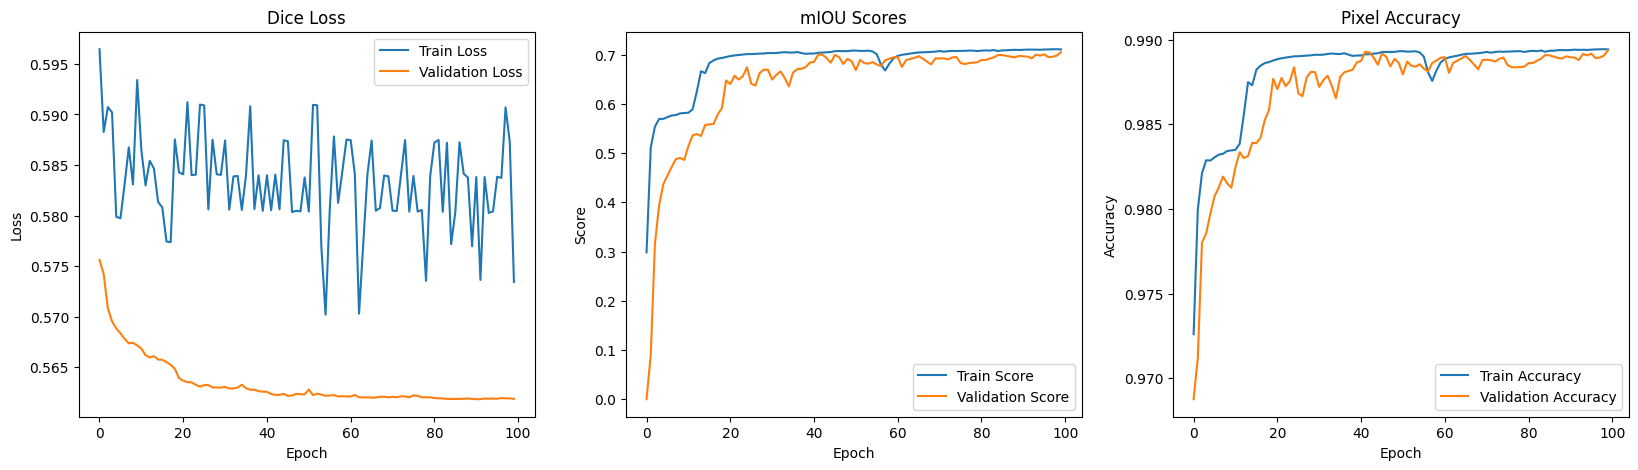

In [3]:
trainVisualization(trainDict, valDict)

In [6]:
avgTrainLoss = np.mean(trainDict['loss'])
avgTrainScore = np.mean(trainDict['score'])
avgTrainPixel= np.mean(trainDict['accuracy'])

avgValLoss = np.mean(valDict['loss'])
avgValScore = np.mean(valDict['score'])
avgValPixel= np.mean(valDict['accuracy'])


print(f"Average Train Dice Loss: {avgTrainLoss:.4f} | Average Train IOU Score: {avgTrainScore:.4f} | Average Train Pixel Accuracy: {avgTrainPixel:.4f}")
print(f"Average Validation Dice Loss: {avgValLoss:.4f} | Average Validation IOU Score: {avgValScore:.4f} | Average Train Pixel Accuracy: {avgValPixel:.4f}")

Average Train Dice Loss: 0.5834 | Average Train IOU Score: 0.6834 | Average Train Pixel Accuracy: 0.9882
Average Validation Dice Loss: 0.5634 | Average Validation IOU Score: 0.6389 | Average Train Pixel Accuracy: 0.9870


Testing

In [9]:
# Loading saved trained model
modelBestDeepLab = torch.load('/content/drive/MyDrive/Cam101/checkpointFPN.pth')

loss = smp.losses.DiceLoss(mode='multilabel', classes=labelKeys)
loss.__name__ = 'Dice_loss'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(modelUnet.parameters(), lr=0.001)
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
]

# Creating the epoch runner
test_epoch = smp.utils.train.ValidEpoch(model=modelBestDeepLab, loss=loss, metrics=metrics, device=DEVICE)

# Executing the test
tracker = test_epoch.run(testloader)

valid: 100%|██████████| 2/2 [00:22<00:00, 11.36s/it, Dice_loss - 0.5935, iou_score - 0.8188, fscore - 0.9004, accuracy - 0.9938]


Visualizing predictions

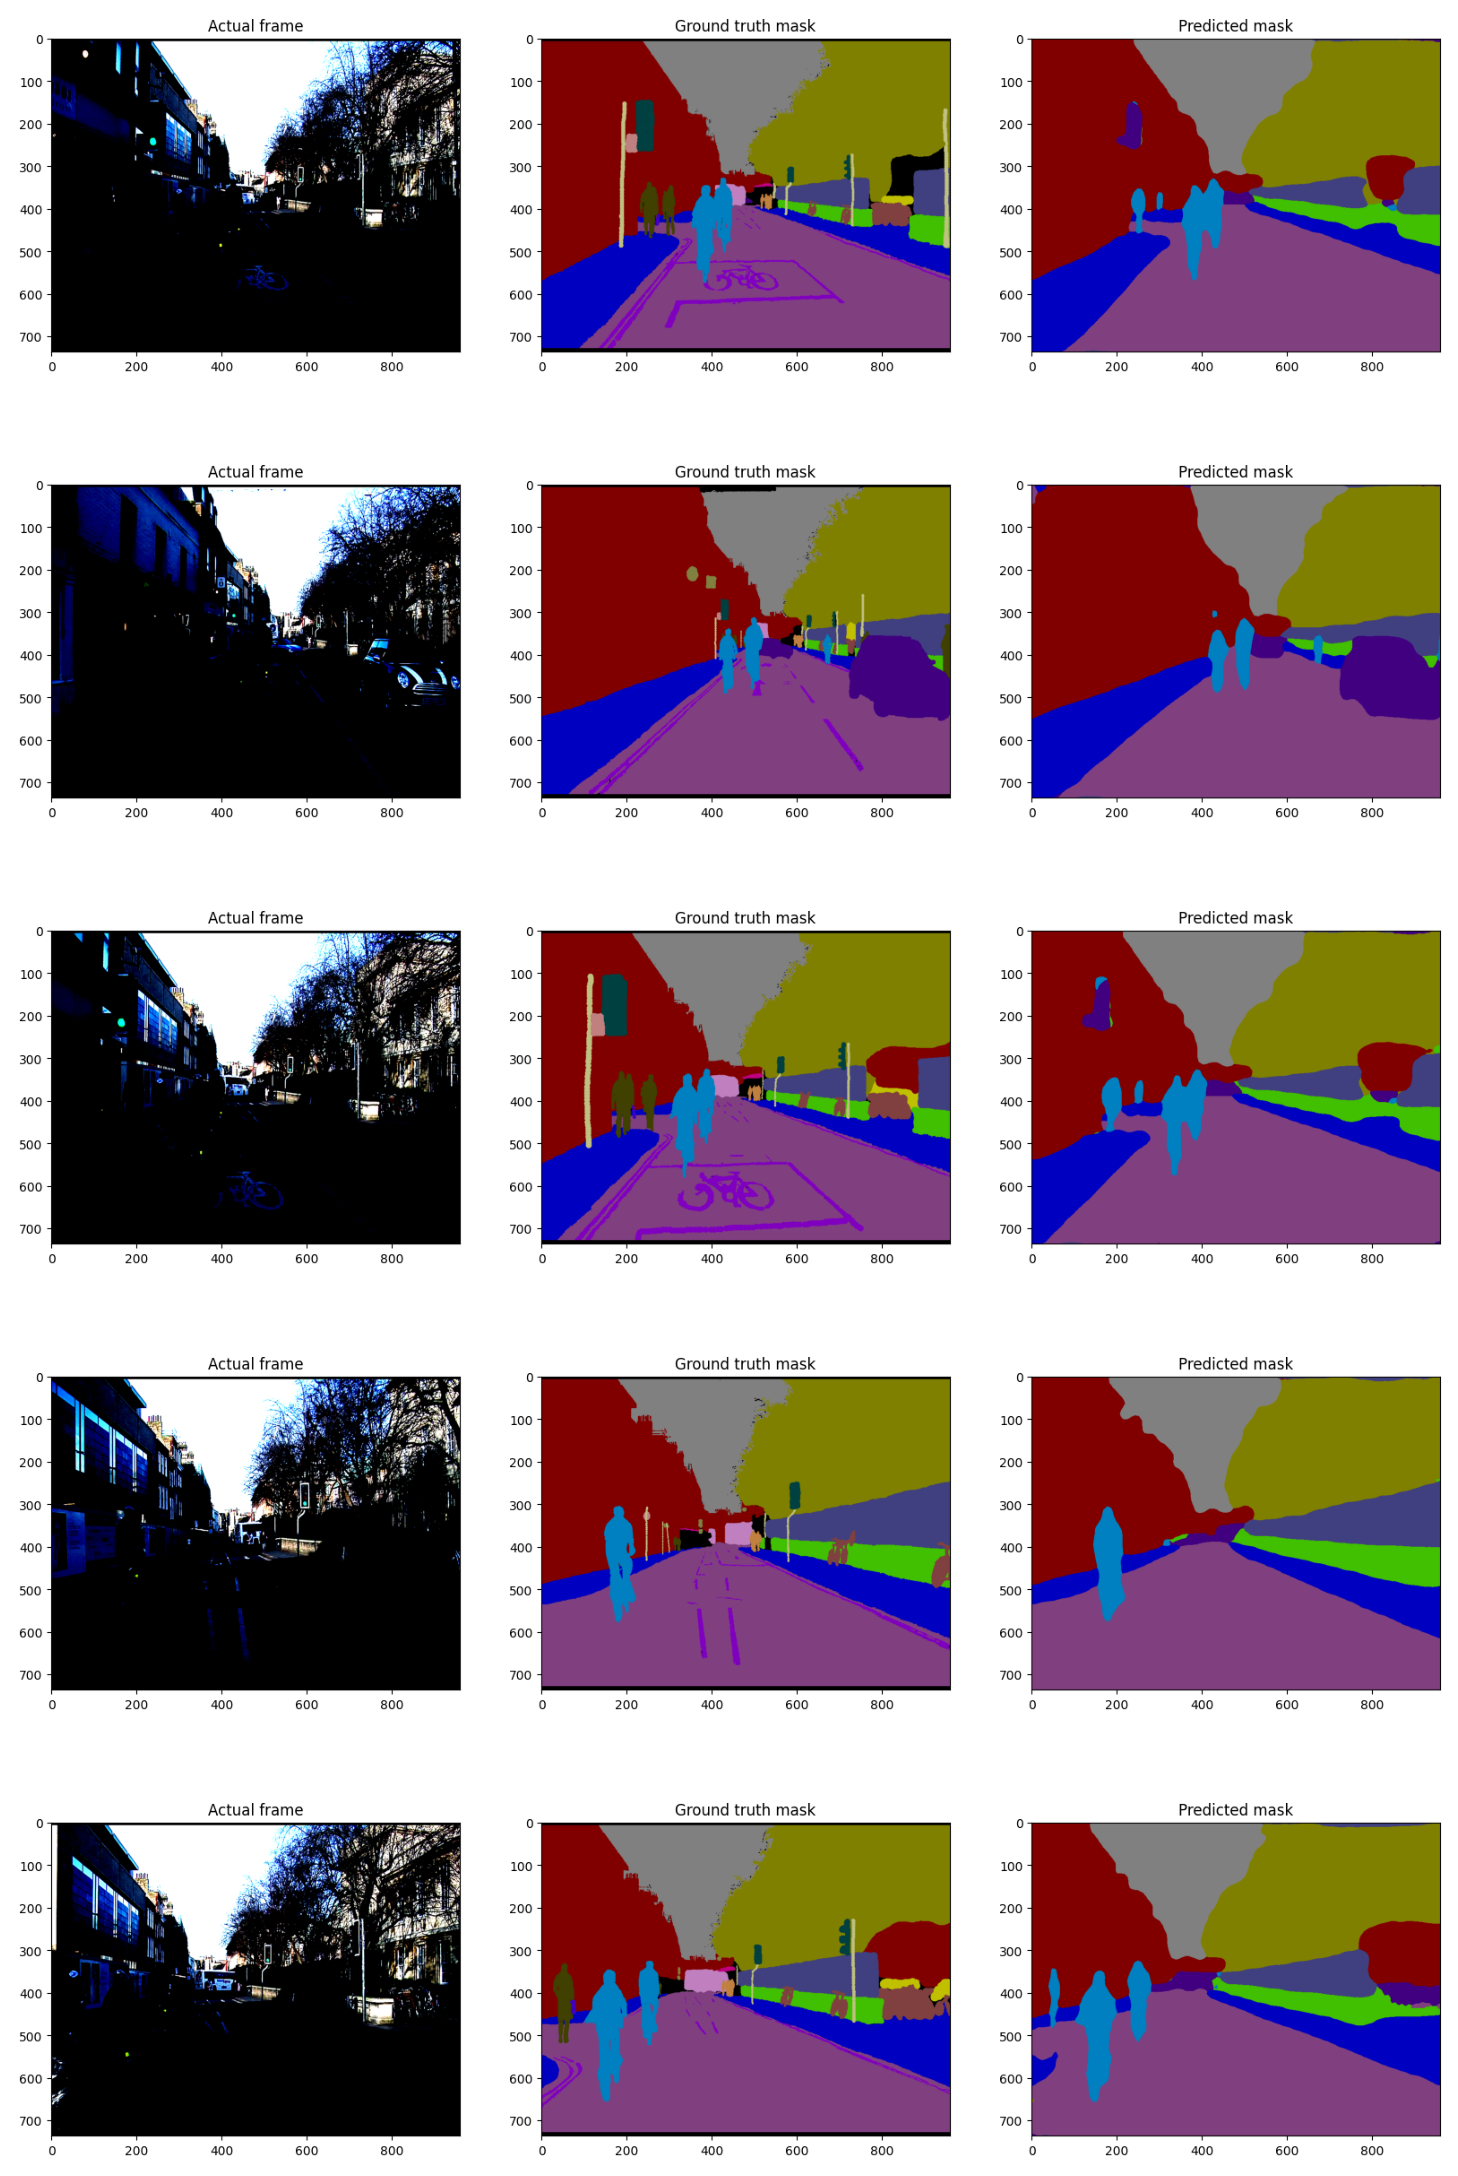

In [10]:
visualiseTest(testloader=testloader, model=modelBestDeepLab)